# 作业二

## Homework 1
证明：模型是条件概率分布，当损失函数是对数损失函数时，经验风险最小化等价于极大似然估计
证明：
若损失函数$L(Y,P(Y|X))$为对数损失函数，则 $L(Y,P(Y|X))=−\log P(Y|X)$,

经验损失：$R_{emp}(f)=\frac{1}{N}\sum_{i=1}^{N} L(y_i,f(x_i))=-\frac{1}{N}\sum_{i=1}^{N} \log P(y_i|x_i)$=$-\frac{1}{N} \log \prod_{i=1}^{N} P(y_i|x_i)$

最小化$R_{emp}$，即最大化$\frac{1}{N} \log \prod_{i=1}^{N} P(y_i|x_i)$，而后者就是似然估计

所以，当损失函数为对数损失函数时，经验风险最小化等价于极大似然估计。

## Homework 2
感知机，见 't1_dummy_data_classify.mlx' 与 't2_boston_house.mlx'

## Homework 3
实现K近邻算法并绘制分类边界

In [1]:
import numpy as np
import scipy.io as io
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from collections import namedtuple
from operator import itemgetter
from pprint import pformat

K近邻：

In [2]:
class KNN:
    """k-nearest neighbor, k-NN
    Parameters
    ----------
    k : int, neighbor number
    metric : {'euclidean', 'manhattan'}
        The metric type of distance.
        'euclidean': the Euclidean distance
        'manhattan': the Manhattan distance
    """
    def __init__(self, metric_type = 'euclidean'):
        if 'euclidean' in metric_type:
            self.metric = lambda x: np.linalg.norm(x, ord = 2, axis = 1)
        elif 'manhattan' in metric_type:
            self.metric = lambda x: np.linalg.norm(x, ord = 1, axis = 1)
        else:
            raise NameError(f'parameter \'metric_type\' got \'{metric_type}\', but \'euclidean\' or \'manhattan\' is expected.')
    def fit(self, X, Y):
        """
        Parameters
        ----------
        X : array, shape (n_samples, n_features), dtype float/double
        Y : array, shape (n_samples,), or list, length n_samples,
            labels of X
        """
        assert (len(X.shape) == 2) & (len(Y.shape) == 1)
        assert X.shape[0] == Y.shape[0]
        self.X = X
        self.Y = Y
    def predict(self, x, k):
        """
        Parameter
        ----------
        x : array, shape (n_samples, n_features), dtype float/double
            the input data to be classified
        
        Return
        ----------
        y : array, shape (n_samples,)
            labels of x
        """
        if (self.X is None) or (self.Y is None):
            raise NotImplementedError('you must train the KNN first')
        assert len(x.shape) == 2
        assert x.shape[1] == self.X.shape[1]
        data_length = x.shape[0]
        y = []
        for item in range(data_length):
            distances = self.metric(self.X - x[item])
            sort_index = np.argsort(distances)[:k] # find the first n-th minimum values
            label = Counter(self.Y[sort_index]).most_common(1)[0][0] # the label of item
            y.append(label)
        return np.array(y)
    def test(self, x, y, k):
        """to test the performance of the trained classifier
        Parameter
        ----------
        x : array, shape (n_samples, n_features), dtype float/double,
            the input data to be classified.
        y : array, shape (n_samples,), or list, length n_samples,
            labels of x
        Return
        ----------
        error : float \in [0,1]
            the error of classifier on the data x
        """
        if (self.X is None) or (self.Y is None):
            raise NotImplementedError('you must train the KNN first')
        assert (len(x.shape) == 2) & (len(y.shape) == 1)
        assert X.shape[0] == len(y)
        pre = self.predict(x, k)
        error = 0
        for i, item in enumerate(pre):
            if item != y[i]:
                error += 1
        return error/len(y)

KD树：

本次代码在[KDTree](https://www.cnblogs.com/gscnblog/p/10566157.html)的基础上改造.

改动：
    1. 增加了Node的属性，'label'
    2. 将最近邻搜索改为k近邻搜索

In [3]:
class Node(namedtuple('Node', 'label location left_child right_child')):
    def __repr__(self):
        return pformat(tuple(self))

class KDTree():
    def __init__(self):
        pass
    def fit(self, points, labels):
        assert (len(points.shape) == 2) & (len(labels.shape) == 1)
        assert points.shape[0] == labels.shape[0]
        if len(points) > 0:
            self.k = len(points[0])
        else:
            self.k = None
        self.tree = self._make_kdtree(points, labels)
        
    def _make_kdtree(self, points, labels, depth=0):
        if len(points) == 0:
            return None
        axis = depth % self.k
        index_sorted = np.argsort(points[:,axis])
        points = points[index_sorted,:]
        labels = labels[index_sorted]
        median = len(points) // 2

        return Node(
            label=labels[median],
            location=points[median],
            left_child=self._make_kdtree(points[:median,:], labels[:median], depth + 1),
            right_child=self._make_kdtree(points[median + 1:,:], labels[median + 1:], depth + 1))
    def predict(self, points, k):
        assert len(points.shape) == 2
        outputs = []
        for points in points:
            label_predict = [label[2] for label in self.find_nearest(points, k)]
            label = Counter(label_predict).most_common(1)[0][0]
            outputs.append(label)
        return np.array(outputs)
            
    def find_nearest(self,
                     point,
                     k = 1,
                     root=None,
                     axis=0,
                     dist_func=lambda x, y: np.linalg.norm(x - y)):
        if root is None:
            root = self.tree
            self._best = []

        if root.left_child or root.right_child:
            new_axis = (axis + 1) % self.k
            if point[axis] < root.location[axis] and root.left_child:
                self.find_nearest(point, k, root.left_child, new_axis)
            elif root.right_child:
                self.find_nearest(point, k, root.right_child, new_axis)

        dist = dist_func(root.location, point).item()

        if len(self._best) < k or (len(self._best) == 0 or dist <= self._best[-1][0]):
            self._best.append((dist, list(root.location), root.label.item()))
            self._best.sort(key = lambda item: item[0])
            self._best = self._best[:k]

        if np.abs(point[axis] - root.location[axis]) <= self._best[-1][0]:
            new_axis = (axis + 1) % self.k
            if root.left_child and point[axis] >= root.location[axis]:
                self.find_nearest(point, k, root.left_child, new_axis)
            elif root.right_child and point[axis] < root.location[axis]:
                self.find_nearest(point, k, root.right_child, new_axis)

        return self._best

用sklearn的KD树，验证本次作业代码的正确性

In [4]:
point_list = np.random.rand(100,3)
labels = np.random.rand(100)
kdtree = KDTree()
kdtree.fit(point_list,labels)
kdtree_sklearn = neighbors.KDTree(point_list)

point = np.array([1,2,3])
kdtree.find_nearest(point, k = 3)
print('作业的KD树结果：',[i[0] for i in kdtree._best])
dist, n = kdtree_sklearn.query(point.reshape(-1,3),k=3)
print('sklearn的KD树结果：',dist[0])

作业的KD树结果： [2.3074953057543213, 2.331393846870629, 2.4480285910310706]
sklearn的KD树结果： [2.30749531 2.33139385 2.44802859]


显示决策边界：

In [5]:
def show_boundary(X, Y, model, n_neighbors):
    h = .05
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    model.fit(X[:,:2],Y)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()],n_neighbors)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification, k = %i"% (n_neighbors))
    plt.show()

In [6]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target
n_neighbors = 3

kdtree = KDTree()
knn = KNN()

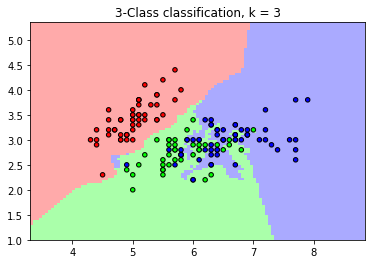

In [7]:
show_boundary(X,Y, knn, n_neighbors = 3)

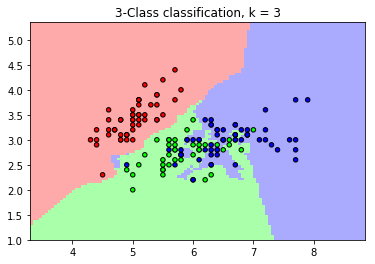

In [8]:
show_boundary(X,Y,kdtree,n_neighbors = 3)